# Jupyter Notebook for Task 3: Cluster Analysis

#### Import Libraries

In [73]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

#### Import Data

In [74]:
charging_data = pd.read_pickle(os.path.join('Data', 'charging_data.pkl'))
weather_data = pd.read_pickle(os.path.join('Data', 'weather_data.pkl'))
merged_data = pd.read_pickle(os.path.join('Data', 'merged_charging_weather_data.pkl'))

## Data preparation for clustering

As a first step, we need to prepare the data for clustering. This includes adding some additional features or filtering/separating the data and scaling the selected features.

In [75]:
# Extract the hour from 'connectionTime' and 'disconnectTime' and at those as features to the charging_data dataframe
charging_data['connection_hour'] = charging_data['connectionTime'].dt.hour
charging_data['disconnect_hour'] = charging_data['disconnectTime'].dt.hour

# Add column 'User' to charging_data dataframe to better differ between registered and unregistered users for evaluation purposes
charging_data['User'] = charging_data['userID'].apply(lambda x: 'Unregistered' if x == '' else 'Registered')

In [76]:
# Scaling the selected features with sklearn's StandardScaler
scaler = StandardScaler()
charging_data_cluster = charging_data
charging_data_cluster_site1 = charging_data[charging_data['siteID'] == '1']
charging_data_cluster_site2 = charging_data[charging_data['siteID'] == '2']
charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster[['kWhDelivered', 'connection_duration']])
charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_site1[['kWhDelivered', 'connection_duration']])
charging_data_cluster_site2[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_site2[['kWhDelivered', 'connection_duration']])

/var/folders/kx/85wpw3bj08164jxdmy5yl7340000gn/T/ipykernel_47400/1399599509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_site1[['kWhDelivered', 'connection_duration']])
/var/folders/kx/85wpw3bj08164jxdmy5yl7340000gn/T/ipykernel_47400/1399599509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_tran

## Clustering

**Selected Clustering algorithm: k-means++** </br>
The k-means++ algorithm is an improved version of the classical k-means algorithm. It focuses on solving the initialization problem of k-means by selecting better initial cluster centroids.
Instead of selecting them randomly (as in classical k-means), k-means++ selects centroids in a way that maximizes the distance between them.
This enhancement helps k-means achieve better clustering results and reduces the likelihood of converging to a suboptimal solution.

### Elbow-Method

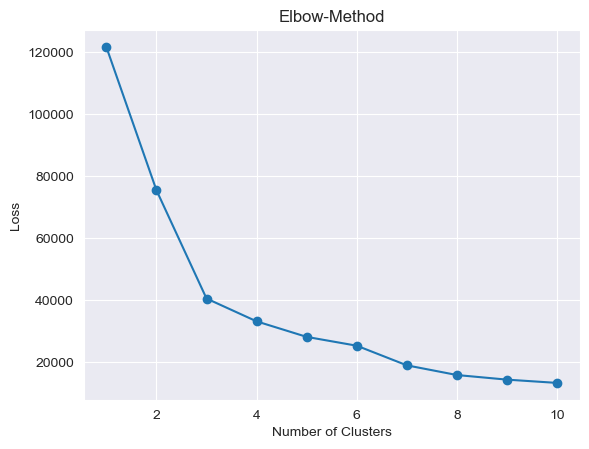

In [77]:
losses = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the loss will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    # init='k-means++' selects k-means++ as the clustering algorithm
    # n_init='auto' defines how often the algorithm is repeated with different random initializations of the cluster centroids. This helps to increase the probability of finding an optimal clustering.
    # random_state=42 ensures that the results of the algorithm are reproducible

    kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'disconnect_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour', 'disconnect_hour']])
    losses.append(kmeans.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), losses, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Elbow-Method')
plt.show()

The Elbow-Method indicates that 3 clusters would be the optimal number of clusters, since adding more clusters no longer significantly improves the clustering performance (Loss reduction becomes minimal).

In [78]:
# Creating multiple clusters
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour', 'disconnect_hour']])

    # Calculate the Silhouette-Score for each kmeans_k with k=2-5
    #score = silhouette_score(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']], charging_data_cluster[f'kmeans_{k}'])
    #print(f"Silhouette Score for k={k}: {score}")

The Silhouette Score is a metric used to evaluate the quality of clustering results. It measures how well-separated the clusters are and how closely data points are grouped within their clusters. The score provides insight into whether the clusters are meaningful and well-defined.

Interpretation of the Silhouette Score: </br>
$S \approx 1$:
Clusters are well-separated, and points are tightly grouped within their clusters.
Indicates excellent clustering.

$S \approx 0$:
Clusters overlap, or the distances between points in the same cluster are similar to distances to points in other clusters.
Indicates unclear cluster boundaries.

$S < 0$:
Points are often closer to a different cluster than to their own.
Indicates poor clustering or misclassification.

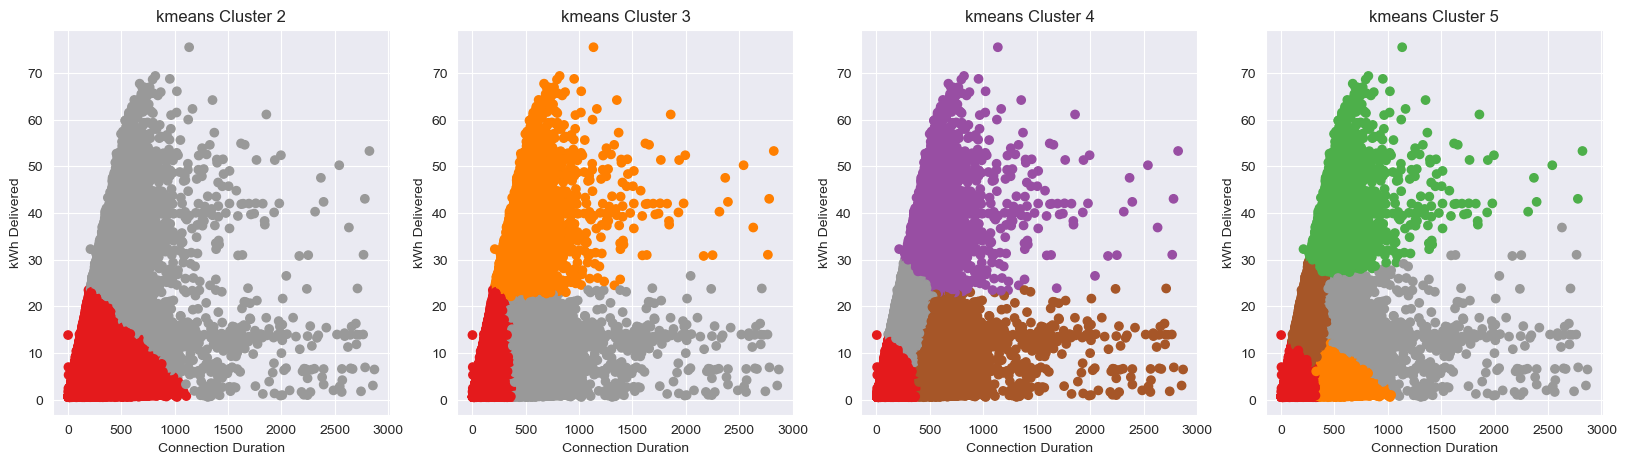

In [79]:
# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster['connection_duration'], y=charging_data_cluster['kWhDelivered'], c=charging_data_cluster[f'kmeans_{i+1}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i+1}')
    ax.set_xlabel('Connection Duration')
    ax.set_ylabel('kWh Delivered')

In [80]:
# Display cluster summaries for kmeans Cluster 2-5
cluster_summaries = {}
for k in range(2, 6):
    cluster_column = f'kmeans_{k}'  # Column name for the current KMeans clustering
    if cluster_column in charging_data_cluster.columns:
        # Group by cluster and calculate mean for relevant features
        summary = charging_data_cluster.groupby(cluster_column)[['kWhDelivered', 'charging_duration', 'connection_duration', 'connection_hour', 'disconnect_hour']].mean()
        # Add cluster sizes
        summary['cluster_size'] = charging_data_cluster[cluster_column].value_counts()
        cluster_summaries[k] = summary

# Display summaries for each KMeans configuration
for k, summary in cluster_summaries.items():
    print(f"\nSummary for KMeans (k={k}):")
    print(summary)


Summary for KMeans (k=2):
          kWhDelivered  charging_duration  connection_duration  \
kmeans_2                                                         
0             7.888202          168.72643           331.292241   
1            28.084788          392.71831           577.270172   

          connection_hour  disconnect_hour  cluster_size  
kmeans_2                                                  
0               10.472594        15.486136         49698  
1                8.783636        15.611909         11134  

Summary for KMeans (k=3):
          kWhDelivered  charging_duration  connection_duration  \
kmeans_3                                                         
0             7.440459         122.919428           173.871487   
1            34.024639         405.542686           517.810949   
2             9.706899         249.584634           560.310399   

          connection_hour  disconnect_hour  cluster_size  
kmeans_3                                               

***

### Site 1

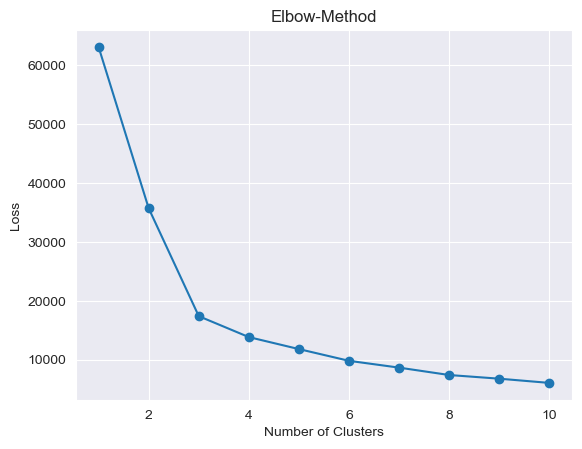

In [81]:
losses_site1 = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the loss will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans_site1 = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    # init='k-means++' selects k-means++ as the clustering algorithm
    # n_init='auto' defines how often the algorithm is repeated with different random initializations of the cluster centroids. This helps to increase the probability of finding an optimal clustering.
    # random_state=42 ensures that the results of the algorithm are reproducible

    kmeans_site1.fit(charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'disconnect_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour', 'disconnect_hour']])
    losses_site1.append(kmeans_site1.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), losses_site1, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Elbow-Method')
plt.show()

In [82]:
# Creating multiple clusters
for k in range(2, 6):
    kmeans_site1 = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    charging_data_cluster_site1[f'kmeans_{k}'] = kmeans_site1.fit_predict(charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour', 'disconnect_hour']])

    # Calculate the Silhouette-Score for each kmeans_k with k=2-5
    #score = silhouette_score(charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']], charging_data_cluster_site1[f'kmeans_{k}'])
    #print(f"Silhouette Score for k={k}: {score}")

/var/folders/kx/85wpw3bj08164jxdmy5yl7340000gn/T/ipykernel_47400/3400370282.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_data_cluster_site1[f'kmeans_{k}'] = kmeans_site1.fit_predict(charging_data_cluster_site1[['kWhDelivered_T', 'connection_duration_T']])
/var/folders/kx/85wpw3bj08164jxdmy5yl7340000gn/T/ipykernel_47400/3400370282.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_data_cluster_site1[f'kmeans_{k}'] = kmeans_site1.fit_predict(charging_data_cluster_site1[['kWhDelivered

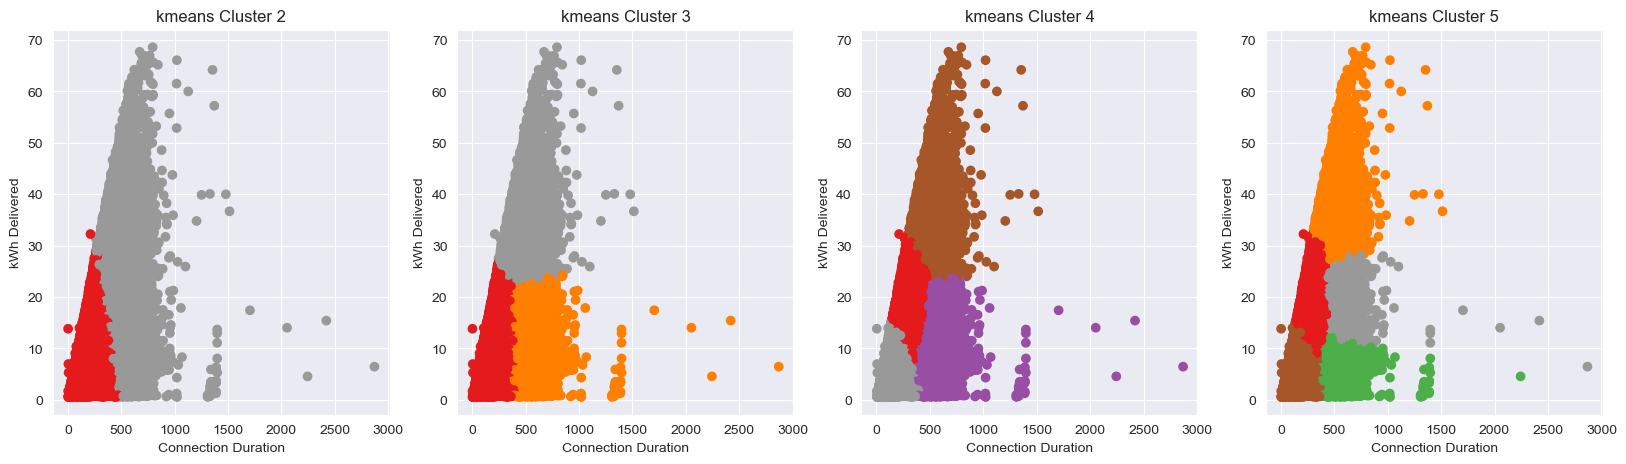

In [83]:
# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster_site1['connection_duration'], y=charging_data_cluster_site1['kWhDelivered'], c=charging_data_cluster_site1[f'kmeans_{i+1}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i+1}')
    ax.set_xlabel('Connection Duration')
    ax.set_ylabel('kWh Delivered')

In [84]:
# Display cluster summaries for kmeans Cluster 2-5
cluster_summaries = {}
for k in range(2, 6):
    cluster_column = f'kmeans_{k}'  # Column name for the current KMeans clustering
    if cluster_column in charging_data_cluster_site1.columns:
        # Group by cluster and calculate mean for relevant features
        summary = charging_data_cluster_site1.groupby(cluster_column)[['kWhDelivered', 'charging_duration', 'connection_duration', 'connection_hour', 'disconnect_hour']].mean()
        # Add cluster sizes
        summary['cluster_size'] = charging_data_cluster_site1[cluster_column].value_counts()
        cluster_summaries[k] = summary

# Display summaries for each KMeans configuration
for k, summary in cluster_summaries.items():
    print(f"\nSummary for KMeans (k={k}):")
    print(summary)


Summary for KMeans (k=2):
          kWhDelivered  charging_duration  connection_duration  \
kmeans_2                                                         
0             9.490738         151.397571           213.749756   
1            17.593556         307.561707           555.999919   

          connection_hour  disconnect_hour  cluster_size  
kmeans_2                                                  
0               11.218836        14.351931         13389  
1                6.997416        15.982792         18189  

Summary for KMeans (k=3):
          kWhDelivered  charging_duration  connection_duration  \
kmeans_3                                                         
0             9.599804         150.882216           206.566422   
1            10.457660         258.043124           563.877289   
2            35.093451         422.612035           520.670429   

          connection_hour  disconnect_hour  cluster_size  
kmeans_3                                               

***

### Site 2

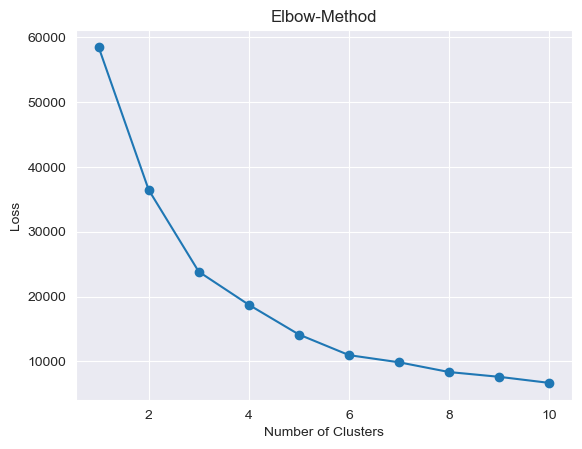

In [85]:
losses_site2 = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the loss will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans_site2 = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    # init='k-means++' selects k-means++ as the clustering algorithm
    # n_init='auto' defines how often the algorithm is repeated with different random initializations of the cluster centroids. This helps to increase the probability of finding an optimal clustering.
    # random_state=42 ensures that the results of the algorithm are reproducible

    kmeans_site2.fit(charging_data_cluster_site2[['kWhDelivered_T', 'connection_duration_T']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'disconnect_hour']])
    #kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour', 'disconnect_hour']])
    losses_site2.append(kmeans_site2.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), losses_site2, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Elbow-Method')
plt.show()

In [86]:
# Creating multiple clusters
for k in range(2, 6):
    kmeans_site2 = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    charging_data_cluster_site2[f'kmeans_{k}'] = kmeans_site2.fit_predict(charging_data_cluster_site2[['kWhDelivered_T', 'connection_duration_T']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T']])
    #charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour', 'disconnect_hour']])

    # Calculate the Silhouette-Score for each kmeans_k with k=2-5
    #score = silhouette_score(charging_data_cluster_site2[['kWhDelivered_T', 'connection_duration_T']], charging_data_cluster_site2[f'kmeans_{k}'])
    #print(f"Silhouette Score for k={k}: {score}")

/var/folders/kx/85wpw3bj08164jxdmy5yl7340000gn/T/ipykernel_47400/2623580254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_data_cluster_site2[f'kmeans_{k}'] = kmeans_site2.fit_predict(charging_data_cluster_site2[['kWhDelivered_T', 'connection_duration_T']])
/var/folders/kx/85wpw3bj08164jxdmy5yl7340000gn/T/ipykernel_47400/2623580254.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_data_cluster_site2[f'kmeans_{k}'] = kmeans_site2.fit_predict(charging_data_cluster_site2[['kWhDelivered

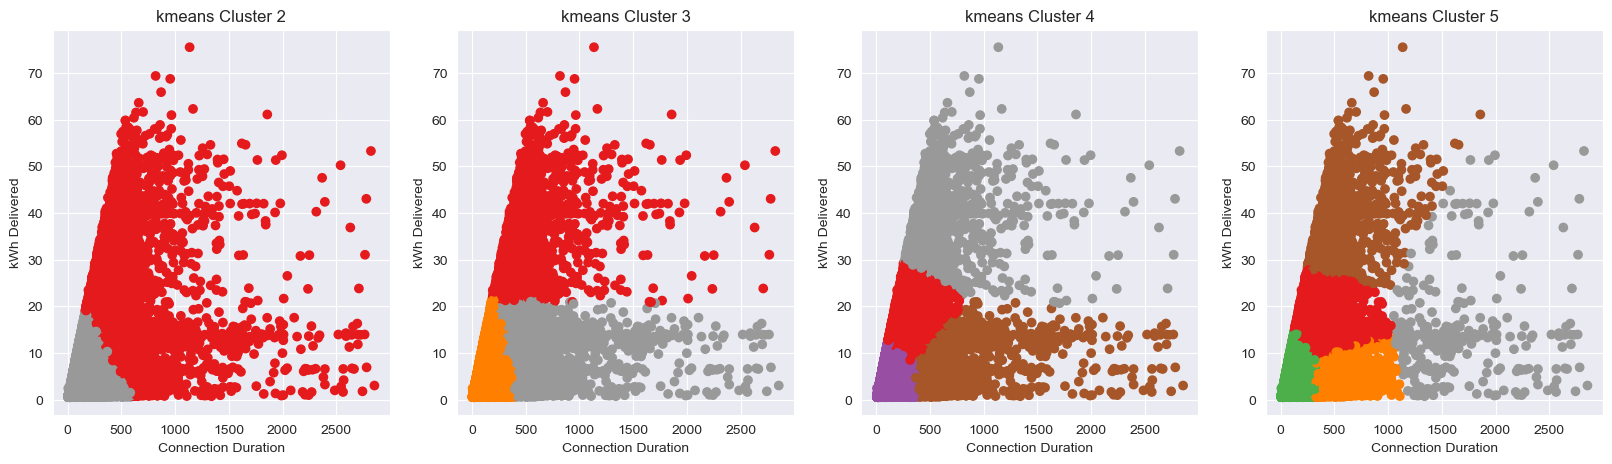

In [87]:
# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster_site2['connection_duration'], y=charging_data_cluster_site2['kWhDelivered'], c=charging_data_cluster_site2[f'kmeans_{i+1}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i+1}')
    ax.set_xlabel('Connection Duration')
    ax.set_ylabel('kWh Delivered')

In [88]:
# Display cluster summaries for kmeans Cluster 2-5
cluster_summaries = {}
for k in range(2, 6):
    cluster_column = f'kmeans_{k}'  # Column name for the current KMeans clustering
    if cluster_column in charging_data_cluster_site2.columns:
        # Group by cluster and calculate mean for relevant features
        summary = charging_data_cluster_site2.groupby(cluster_column)[['kWhDelivered', 'charging_duration', 'connection_duration', 'connection_hour', 'disconnect_hour']].mean()
        # Add cluster sizes
        summary['cluster_size'] = charging_data_cluster_site2[cluster_column].value_counts()
        cluster_summaries[k] = summary

# Display summaries for each KMeans configuration
for k, summary in cluster_summaries.items():
    print(f"\nSummary for KMeans (k={k}):")
    print(summary)


Summary for KMeans (k=2):
          kWhDelivered  charging_duration  connection_duration  \
kmeans_2                                                         
0            14.259482         282.071167           570.416018   
1             5.477208         110.552606           197.657494   

          connection_hour  disconnect_hour  cluster_size  
kmeans_2                                                  
0               10.195997        16.054273         11092  
1               12.536340        15.555005         18162  

Summary for KMeans (k=3):
          kWhDelivered  charging_duration  connection_duration  \
kmeans_3                                                         
0            33.082854         380.434928           559.217449   
1             5.964523         102.258163           150.223388   
2             9.004378         241.413724           552.726949   

          connection_hour  disconnect_hour  cluster_size  
kmeans_3                                               

***

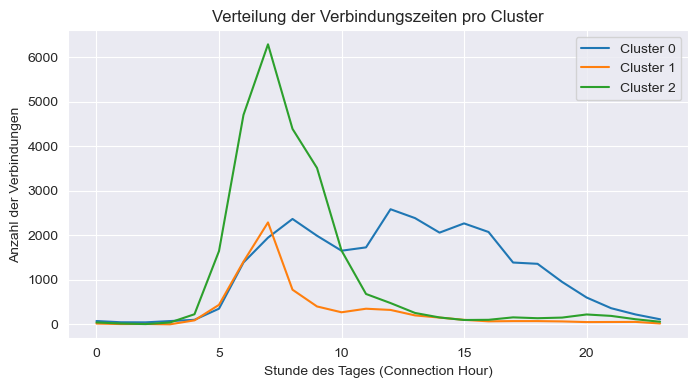

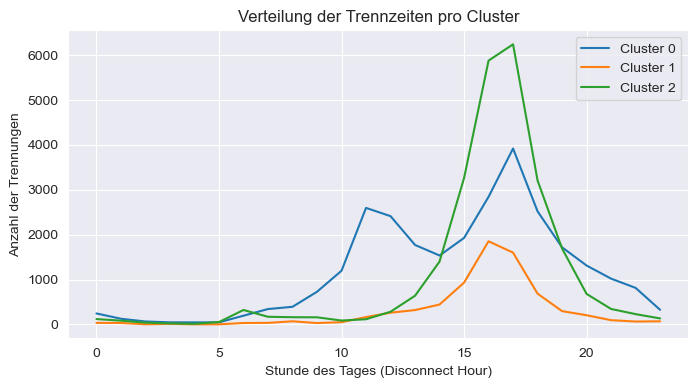

In [89]:
# Gruppieren der Daten nach Cluster und Stunde
connection_hourly = charging_data_cluster.groupby(['kmeans_3', 'connection_hour']).size().unstack(fill_value=0)
disconnect_hourly = charging_data_cluster.groupby(['kmeans_3', 'disconnect_hour']).size().unstack(fill_value=0)

# Liniendiagramm für Verbindungszeiten
plt.figure(figsize=(8, 4))
for cluster in connection_hourly.index:
    plt.plot(connection_hourly.columns, connection_hourly.loc[cluster], label=f'Cluster {cluster}')

plt.title('Verteilung der Verbindungszeiten pro Cluster')
plt.xlabel('Stunde des Tages (Connection Hour)')
plt.ylabel('Anzahl der Verbindungen')
plt.legend()
plt.grid(True)
plt.show()

# Liniendiagramm für Trennzeiten
plt.figure(figsize=(8, 4))
for cluster in disconnect_hourly.index:
    plt.plot(disconnect_hourly.columns, disconnect_hourly.loc[cluster], label=f'Cluster {cluster}')

plt.title('Verteilung der Trennzeiten pro Cluster')
plt.xlabel('Stunde des Tages (Disconnect Hour)')
plt.ylabel('Anzahl der Trennungen')
plt.legend()
plt.grid(True)
plt.show()

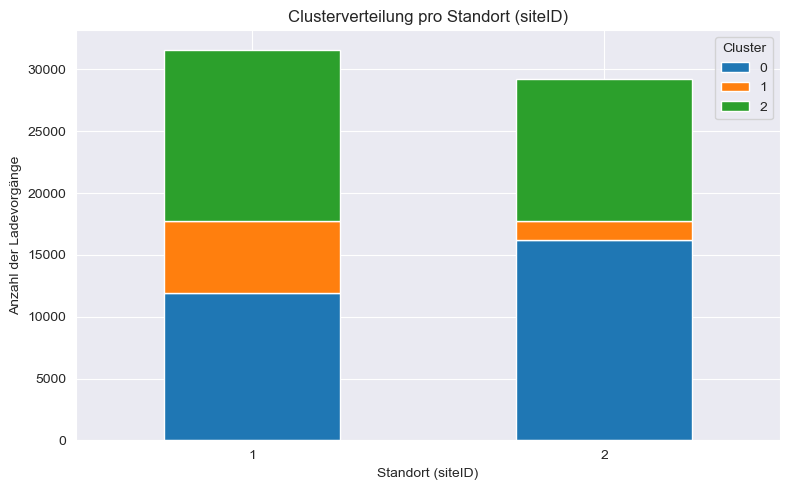

In [90]:
# Gruppieren der Daten nach `siteID` und Cluster
site_cluster_counts = charging_data_cluster.groupby(['siteID', 'kmeans_3']).size().unstack(fill_value=0)

# Bar Chart der Clusterverteilung pro Standort
site_cluster_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Clusterverteilung pro Standort (siteID)')
plt.xlabel('Standort (siteID)')
plt.ylabel('Anzahl der Ladevorgänge')
plt.legend(title='Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

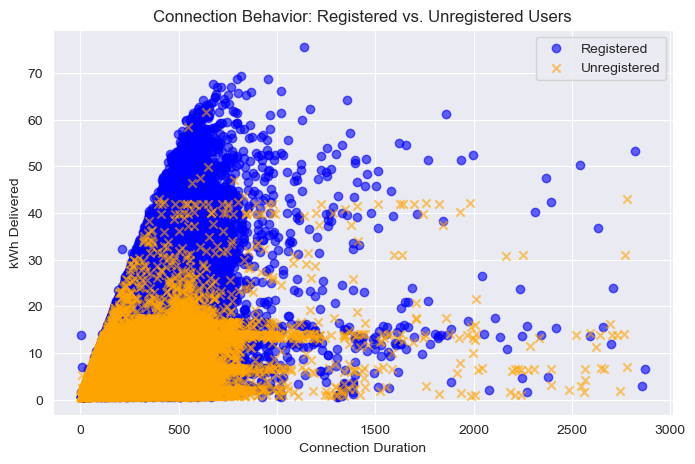

In [91]:
# Separate the data into registered and unregistered users
registered_users = charging_data_cluster[charging_data_cluster['User'] == 'Registered']
unregistered_users = charging_data_cluster[charging_data_cluster['User'] == 'Unregistered']

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x=registered_users['connection_duration'], y=registered_users['kWhDelivered'], c='blue', label='Registered', alpha=0.6, marker='o')
plt.scatter(x=unregistered_users['connection_duration'], y=unregistered_users['kWhDelivered'], c='orange', label='Unregistered', alpha=0.6, marker='x')

plt.title('Connection Behavior: Registered vs. Unregistered Users')
plt.xlabel('Connection Duration')
plt.ylabel('kWh Delivered')
plt.legend()
plt.grid(True)
plt.show()